In [47]:
import sys
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)
from cmap import Colormap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim

from gait_dataset import GaitDataset
from gait_model import GaitGRUModel

torch.manual_seed(114514)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EH

# Data load

In [119]:
batch_size = 32

ds = torch.load('dataset/gait_o.pt')
index_tensor = torch.arange(len(ds))

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size

generator = torch.Generator().manual_seed(10086)
train_ds, test_ds = random_split(ds, (train_size, test_size), generator=generator)
index_train, index_test = random_split(index_tensor, (train_size, test_size), generator=generator)

train_loader, test_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False), DataLoader(test_ds, batch_size=batch_size, shuffle=False)
index_train_loader, index_test_loader = DataLoader(index_train, batch_size=batch_size, shuffle=False), DataLoader(index_test, batch_size=batch_size, shuffle=False)

# Hyperparameters

In [3]:
input_dim = 8
hidden_dim = 128
layer_dim = 1
output_dim = len(torch.unique(ds.labels)) # Number of classes
dropout_prob = 0

reduced_chnl = 4
kernel_size = 100
stride = 100

num_epochs = 100

# Training

In [4]:
print(ds.features.shape)
print(ds.labels.shape)

torch.Size([924, 8, 1500])
torch.Size([924])


## Train a new model

In [120]:
model = GaitGRUModel(input_dim, hidden_dim, layer_dim, output_dim,
                     reduced_chnl, kernel_size, stride).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.01)

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GaitGRUModel(
  (channel_weights): Linear(in_features=8, out_features=4, bias=True)
  (seq_reduction_conv): Conv1d(4, 4, kernel_size=(100,), stride=(100,), padding=(1,))
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=13, bias=True)
  (softmax): LogSoftmax(dim=1)
)
54773


In [30]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0

    raw_predicted = []

    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device).float(), labels.to(device).long()

        # print(features.shape)
        outputs = model(features)
        # print(outputs.shape)

        loss = criterion(outputs, labels.squeeze())
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        raw_predicted.append(predicted)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device).float(), labels.to(device).long()
            outputs = model(features)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            raw_predicted.append(predicted)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / total_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \
            Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

 21%|██        | 21/100 [00:02<00:08,  8.85it/s]

Epoch [20/100], Train Loss: 1.0698, Train Accuracy: 0.6049,             Test Loss: 1.1170, Test Accuracy: 0.6000


 41%|████      | 41/100 [00:04<00:06,  8.79it/s]

Epoch [40/100], Train Loss: 0.6417, Train Accuracy: 0.7673,             Test Loss: 0.6942, Test Accuracy: 0.7405


 61%|██████    | 61/100 [00:07<00:04,  8.85it/s]

Epoch [60/100], Train Loss: 0.3587, Train Accuracy: 0.8850,             Test Loss: 0.4281, Test Accuracy: 0.8811


 81%|████████  | 81/100 [00:09<00:02,  8.56it/s]

Epoch [80/100], Train Loss: 0.1963, Train Accuracy: 0.9459,             Test Loss: 0.2935, Test Accuracy: 0.9135


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]

Epoch [100/100], Train Loss: 0.1575, Train Accuracy: 0.9594,             Test Loss: 0.2422, Test Accuracy: 0.9405


## Use an existing model

In [121]:
model.load_state_dict(torch.load('model_o.pt'))
model.to(device)

GaitGRUModel(
  (channel_weights): Linear(in_features=8, out_features=4, bias=True)
  (seq_reduction_conv): Conv1d(4, 4, kernel_size=(100,), stride=(100,), padding=(1,))
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=13, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [122]:
unshuffled_loader = DataLoader(ds, batch_size=1, shuffle=False)

y_pred = []
y_true = []
scores = []

model.eval()

with torch.no_grad():
    for feature, label in unshuffled_loader:
        feature = feature.to(device).float()
        label = label.to(device).float()
        outputs = model(feature)

        exp_outputs = torch.exp(outputs).cpu()
        pred = torch.argmax(exp_outputs, axis=1).cpu().numpy()

        y_pred.extend(pred)
        y_true.extend(label.cpu().numpy())
        scores.append(exp_outputs)

y_pred = np.array(y_pred)
y_true = np.array(y_true)
scores = torch.cat(scores).numpy()
scores = np.around(scores, 5)

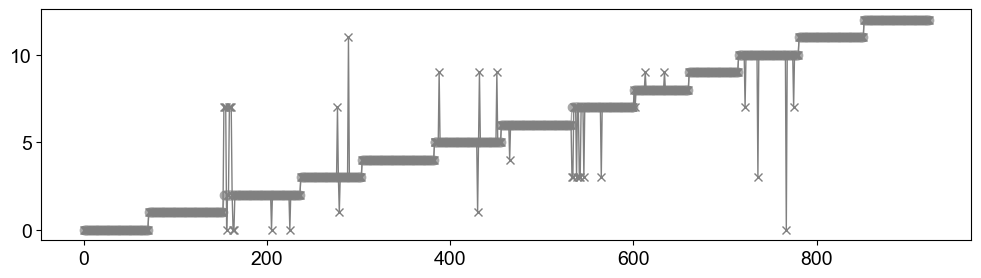

In [123]:
plt.figure(figsize=(12, 3))
plt.plot(y_true, 'o-', color='darkgray')
plt.plot(y_pred, 'x-', color='gray')
# plt.xlim(0, 200)

plt.savefig('results/prediction/oxene_pred.png', dpi=600, bbox_inches='tight')

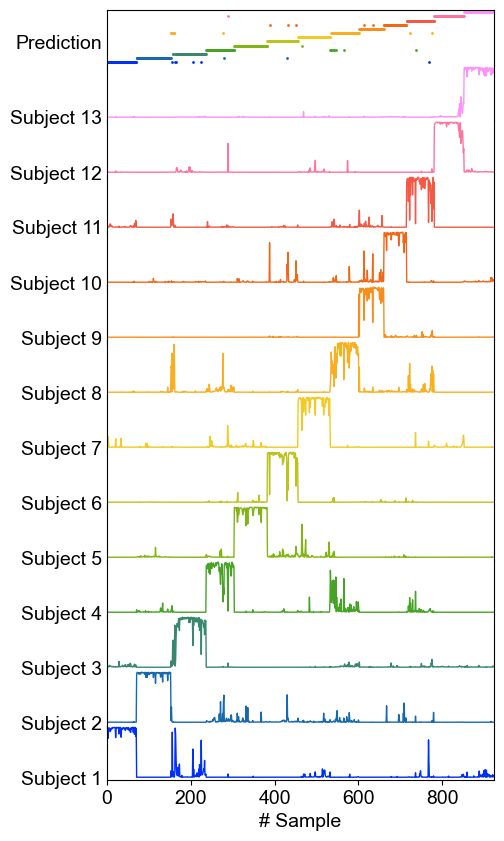

In [124]:
num_labels = len(np.unique(y_true))
colors = Colormap('colorcet:cet_r1')(np.linspace(0, 1, num_labels))

fig, axes = plt.subplots(nrows=len(np.unique(y_pred)) + 1, ncols=1, sharex=True, figsize=(5, 10))
fig.subplots_adjust(hspace=0)

for idx, ax in enumerate(axes.flat):
    ax.tick_params(axis='y', length=0)
    ax.set_yticks([0], labels=['Subject ' + str(num_labels - idx + 1)])
    if idx == 0:  # first row
        for j, value in enumerate(np.unique(y_pred)):
            ax.plot(np.arange(len(y_pred))[y_pred == value], y_pred[y_pred == value],
                    'o', ms=2, mec='None', mfc=colors[j])
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks([5], labels=['Prediction'])
    elif 0 < idx < num_labels:
        ax.plot(scores[:, scores.shape[1] - idx], c=colors[num_labels - idx])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    else:  # last row
        ax.plot(scores[:, scores.shape[1] - idx], c=colors[num_labels - idx])
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('# Sample')

plt.xlim(0, len(ds))
# plt.savefig('results/prediction/mxene.png', dpi=600, bbox_inches='tight')
plt.show()

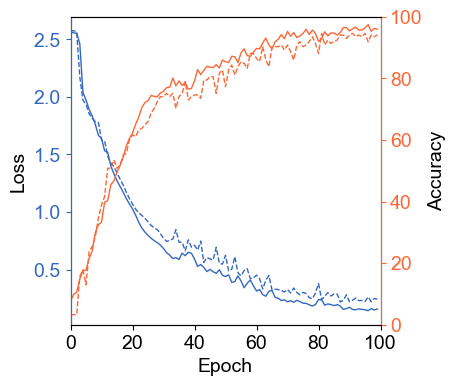

In [35]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.tick_params(axis='y', color='#3468C0', labelcolor='#3468C0')
plt.plot(train_losses, c='#3468C0')
plt.plot(test_losses, '--', c='#3468C0')
plt.xlim(0, 100)
plt.ylabel('Loss')
plt.xlabel('Epoch')

ax = ax.twinx()
ax.tick_params(axis='y', color='#FC6736', labelcolor='#FC6736')
plt.plot(100 * np.array(train_accuracies), c='#FC6736')
plt.plot(100 * np.array(test_accuracies), '--', c='#FC6736')
plt.ylabel('Accuracy')
plt.ylim(0, 100)

ax.spines['left'].set_edgecolor('#3468C0')
ax.spines['right'].set_edgecolor('#FC6736')

# plt.savefig('results/training/training_curve_o.png', dpi=600, bbox_inches='tight')

In [9]:
print("Model's state_dict: ")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict: 
channel_weights.weight 	 torch.Size([4, 8])
channel_weights.bias 	 torch.Size([4])
seq_reduction_conv.weight 	 torch.Size([4, 4, 100])
seq_reduction_conv.bias 	 torch.Size([4])
gru.weight_ih_l0 	 torch.Size([384, 4])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
fc.weight 	 torch.Size([13, 128])
fc.bias 	 torch.Size([13])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2400.), 'exp_avg': tensor([[ 0.0052, -0.0230,  0.0084, -0.0082,  0.0420,  0.0208,  0.0217,  0.0825],
        [ 0.0302,  0.0137,  0.0136, -0.0102, -0.0146,  0.0347,  0.0123, -0.0186],
        [ 0.0295,  0.0296, -0.0025,  0.0263, -0.0541, -0.0151, -0.0154, -0.1141],
        [-0.0002, -0.0219, -0.0215,  0.0177, -0.0023, -0.0128,  0.0012, -0.0120]],
       device='cuda:0'), 'exp_avg_sq': tensor([[0.0490, 0.0369, 0.0331, 0.0453, 0.0594, 0.0351, 0.0351, 0.1169],
        [0.1422, 0.0545, 0.0789, 0.0724, 0.1240, 0.0444, 0.0535, 0.1804],
  

In [36]:
torch.save(model.state_dict(), 'model_o.pt')

___
# Visualization


In [37]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device).float()
        labels = labels.to(device)
        outputs = model(features)
        # print(outputs)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(outputs)
        y_true.extend(labels.cpu().numpy())

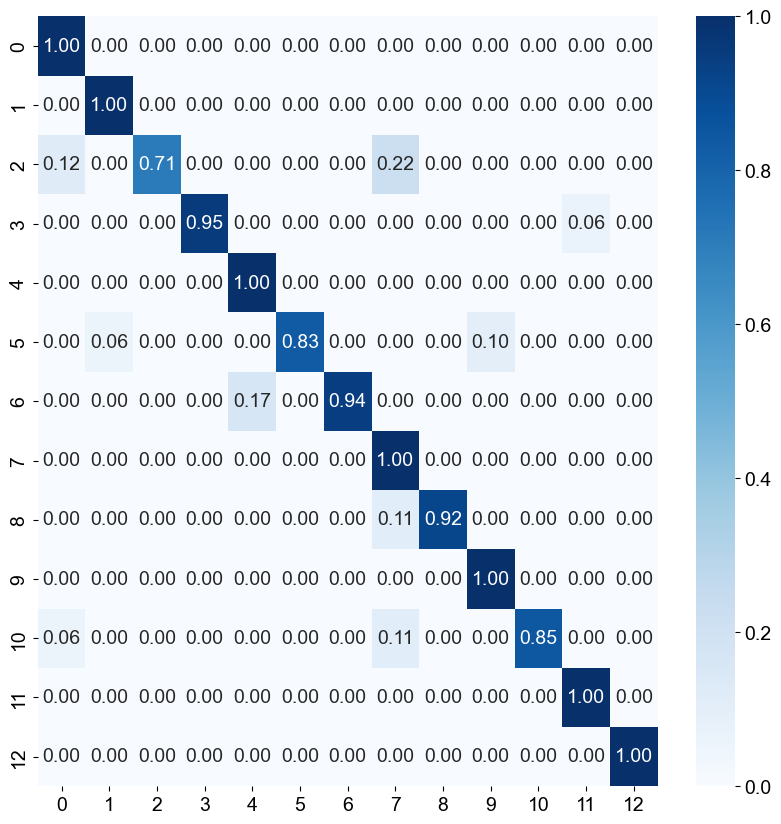

In [38]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm / np.sum(cm, axis=1), annot=True, fmt='.2f', cmap='Blues')

# plt.savefig('results/training/cm_o.png', dpi=600, bbox_inches='tight')
plt.show()